<a href="https://colab.research.google.com/github/DarxinZ/ML/blob/main/T8_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

class ITrainable:
    def __init__(self):
        pass

    def forward_propagation(self, prev_A):
        raise NotImplementedError("forward_propagation not implemented: ITrainable is an interface")

    def backward_propagation(self, dA):
        raise NotImplementedError("backward_propagation not implemented: ITrainable is an interface")

    def update_parameters(self):
        raise NotImplementedError("update_parameters not implemented: ITrainable is an interface")

class DLLinearFamily(ITrainable):
    def __init__(self,name, n, alpha, optimization=None):
        self.name = name
        self.alpha = alpha
        self.optimization = optimization
        self.W = np.zeros((n,1),dtype=float)
        self.b = 0
        # optimization parameters
        if self.optimization == 'adaptive':
            self.adaptive_cont = 1.1
            self.adaptive_switch = 0.5
            self.adaptive_W = np.full(self.W.shape,alpha,dtype=float)
            self.adaptive_b = alpha
            
    def __str__(self):
        s = f"{self.name} Function:\n"
        s += f"\tlearning_rate (alpha): {self.alpha}\n"
        if self.optimization != None:
            s += f"\tOptimization: {self.optimization}\n"
            if self.optimization == "adaptive":
                s += f"\t\tadaptive parameters:\n"
                s += f"\t\t\tcont: {self.adaptive_cont}\n"
                s += f"\t\t\tswitch: {self.adaptive_switch}\n"
        s += "\tParameters:\n"
        s += f"\t\tW shape: {self.W.shape}\n"
        s += f"\t\tb: {self.b}\n"
        return s;


    def forward_propagation(self, prev_A):
        self.prev_A = np.copy(prev_A)
        Z = self.W.T@prev_A+self.b
        return Z

    def backward_propagation(self, dZ):
        db_m_values = dZ * np.full((1,self.prev_A.shape[1]),1)
        dW_n_m_values = dZ * self.prev_A
        self.db = np.sum(db_m_values, keepdims=True, axis=1)
        self.dW = np.sum(dW_n_m_values, keepdims=True, axis=1)
    
    def update_parameters(self):
        if self.optimization == 'adaptive':
            self.adaptive_W *= np.where(self.adaptive_W * self.dW > 0, self.adaptive_cont, -self.adaptive_switch)
            self.W -= self.adaptive_W 
            if self.adaptive_b * self.db > 0:
                self.adaptive_b *= self.adaptive_cont
            else:
                self.adaptive_b *= -self.adaptive_switch
            self.b -= self.adaptive_b 
        else:
            self.W -= self.alpha * self.dW
            self.b -= self.alpha * self.db

class DLLinearLayer(ITrainable):
    def __init__(self,name, num_units,input_size, alpha,optimization=None):
        self.name = name
        self.alpha = alpha
        self.num_units = num_units
        self.input_size = input_size
        self.optimization = optimization
        ##self.W = np.zeros((n,1),dtype=float)
        self.W = DLLinearLayer.normal_initialization((num_units,input_size))
        self.b = np.zeros((num_units,1),dtype=float)
        # optimization parameters
        if self.optimization == 'adaptive':
            self.adaptive_cont = 1.1
            self.adaptive_switch = 0.5
            self.adaptive_W = np.full(self.W.shape,alpha,dtype=float)
            self.adaptive_b = np.full(self.b.shape,alpha,dtype=float)
            ##self.adaptive_b = alpha
    
    def __str__(self):
        s = f"{self.name} Function:\n"
        s += f"\tlearning_rate (alpha): {self.alpha}\n"
        if self.optimization != None:
            s += f"\tOptimization: {self.optimization}\n"
            if self.optimization == "adaptive":
                s += f"\t\tadaptive parameters:\n"
                s += f"\t\t\tcont: {self.adaptive_cont}\n"
                s += f"\t\t\tswitch: {self.adaptive_switch}\n"
        s += "\tParameters:\n"
        s += f"\t\tW shape: {self.W.shape}\n"
        s += f"\t\tb: {self.b.shape}\n"
        s += f"\t\tnum units: {self.num_units}\n"
        s += f"\t\tinput size: {self.input_size}\n"
        return s;


    def forward_propagation(self, prev_A):
        self.prev_A = np.copy(prev_A)
        ##Z = self.W.T@prev_A+self.b
        Z = self.W@prev_A+self.b
        return Z

    def backward_propagation(self, dZ):
        db_m_values = dZ * np.full((1,self.prev_A.shape[1]),1)
        ##dW_n_m_values = dZ * self.prev_A
        ##self.db = np.sum(db_m_values, keepdims=True, axis=1)
        ##self.dW = np.sum(dW_n_m_values, keepdims=True, axis=1)
        self.dW = dZ@self.prev_A.T
        self.db = np.sum(db_m_values, keepdims=True, axis=1)
        dA_prev = self.W.T@dZ
        return dA_prev


    
    def update_parameters(self):
        if self.optimization == 'adaptive':
            self.adaptive_W *= np.where(self.adaptive_W * self.dW > 0, self.adaptive_cont, -self.adaptive_switch)
            self.W -= self.adaptive_W 
            ##if self.adaptive_b * self.db > 0:
            ##    self.adaptive_b *= self.adaptive_cont
            ##else:
            ##    self.adaptive_b *= -self.adaptive_switch
            ##self.b -= self.adaptive_b 
            self.adaptive_b *= np.where(self.adaptive_b * self.db > 0, self.adaptive_cont, -self.adaptive_switch)
            self.b -= self.adaptive_b 
        else:
            self.W -= self.alpha * self.dW
            self.b -= self.alpha * self.db

    @staticmethod
    def normal_initialization(shape,factor=0.01): 
        ##W1 = np.random.randn(shape[0],shape[1]) * factor
        W1 = np.random.randn(*shape) * factor
        return W1



class DLNetwork(ITrainable):
    def __init__(self,name):
        self.name = name
        self.layers = []

    def __str__(self):
        s = f"{self.name}:\n"
        for l in self.layers:
            s += str(l)
        return s

    def add(self,iTrainable):
        for l in self.layers:
            if l.name == iTrainable.name:
                raise ValueError(f"{iTrainable.name} already exists")
        self.layers.append(iTrainable)

    def forward_propagation(self,X):
        Al=X
        for l in self.layers:
           Al = l.forward_propagation(Al)
        return Al

    def backward_propagation(self, dY_hat):
        dAl = dY_hat
        for l in reversed(self.layers):
           dAl = l.backward_propagation(dAl)
        return dAl

    def update_parameters(self):
        for l in self.layers:
           l.update_parameters()

class DLActivation(ITrainable):
##    def __init__(self):
##        self.name = "Sigmoid"
    def __init__(self, activation):
        self.name = activation

    def __str__(self):
        return "Activation function: "+self.name+"\n"
    
    def forward_propagation(self,Z):
        if self.name == "sigmoid":
            self.S = 1/(1+np.exp(-Z))
            return self.S
        if self.name == "tanh":
            self.S = np.tanh(Z)
            return self.S
        if self.name == "relu":
            self.Z = Z
            return np.maximum(0,Z)
        if self.name == "leaky_relu":
            self.leakyRelu_d = 0.01
            self.Z = Z
            return np.where(Z <= 0, self.leakyRelu_d*Z, Z)
        raise NotImplementedError("Unimplemented activation:", self.name)

    def backward_propagation(self, dS):
        if self.name == "sigmoid":
            return dS * self.S * (1-self.S)
        if self.name == "tanh":
            return dS * (1-self.S * self.S)
        if self.name == "relu":
            return dS * np.where(self.Z <= 0, 0, 1)
        if self.name == "leaky_relu":
            return dS * np.where(self.Z <= 0, self.leakyRelu_d, 1)
        raise NotImplementedError("Unimplemented activation:", self.name)
    
    def update_parameters(self):
        pass

class DLPerceptron(DLNetwork):
    def __init__(self, name, n, alpha, optimization=None):
        DLNetwork.__init__(self, name)
        self.linear = DLLinearFamily("linear", n, alpha, optimization)
        self.sigmoid = DLActivation()
        self.add(self.linear)
        self.add(self.sigmoid)

class DLNeuronsLayer(DLNetwork):
    def __init__(self,name,num_units,input_size, activation, alpha,optimization=None):
        DLNetwork.__init__(self, name)
        self.linear = DLLinearLayer("linear", num_units,input_size, alpha,optimization)
        self.sigmoid = DLActivation(activation)
        self.add(self.linear)
        self.add(self.sigmoid)

class DLModel:
    def __init__(self,name,iTrainable, loss):
        self.name = name
        self.iTrainable = iTrainable
        self.loss = loss
        if loss == "square_dist":
            self.loss_forward = self.square_dist
            self.loss_backward = self.dSquare_dist
        elif loss == "cross_entropy":
            self.loss_forward = self.cross_entropy
            self.loss_backward = self.dCross_entropy
        else:
            raise NotImplementedError("Unimplemented loss function: " + loss)

    def __str__(self):
        s = self.name + "\n"
        s += "\tLoss function: " + self.loss + "\n"
        s += "\t"+str(self.iTrainable) + "\n"
        return s


    def square_dist(self, Y_hat, Y):
        errors = (Y_hat - Y)**2
        return errors

    def dSquare_dist(self, Y_hat, Y):
        m = Y.shape[1]
        dY_hat = 2*(Y_hat - Y)/m
        return dY_hat

    def compute_cost(self, Y_hat, Y):
        m = Y.shape[1]
        errors = self.loss_forward(Y_hat, Y)
        J = np.sum(errors)
        return J/m

    def cross_entropy(self, Y_hat, Y):
        logprobs = -((1 - Y)*np.log(1 - Y_hat)+Y*np.log(Y_hat))
        return logprobs

    def dCross_entropy(self, Y_hat, Y):
        m = Y_hat.shape[1]
        dY_hat =(1-Y)/(1-Y_hat)-Y/Y_hat
        return dY_hat/m

    def train(self, X, Y, num_iterations):
        print_ind = max(num_iterations // 100, 1)
        costs = []
        for i in range(num_iterations):
            Y_hat = self.forward_propagation(X)
            self.backward_propagation(Y_hat, Y)
            self.update_parameters()
            #record progress
            if i > 0 and i % print_ind == 0:
                J = self.compute_cost(Y_hat, Y)
                costs.append(J)
                print("cost after ", str(i+1), "updates ("+str(i//print_ind)+"%):",str(J))
        costs.append(self.compute_cost(Y_hat, Y))
        return costs

    def forward_propagation(self, X):
        return self.iTrainable.forward_propagation(X)

    def backward_propagation(self, Y_hat,Y):
        dY_hat = self.loss_backward(Y_hat, Y)
        self.iTrainable.backward_propagation(dY_hat)

    def update_parameters(self):
        self.iTrainable.update_parameters()

In [2]:
!cp /content/drive/MyDrive/Data/unit10/utils.py .
import utils as u10

In [3]:
import numpy as np
#from DL5 import *
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
#from unit10 import utils as u10

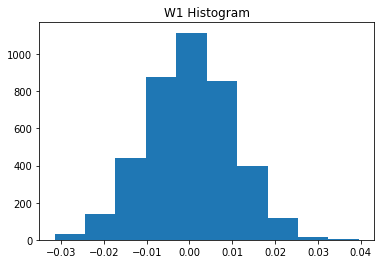

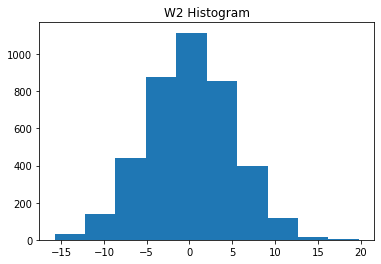

In [4]:
import matplotlib.pyplot as plt
np.random.seed(1)
W1 = DLLinearLayer.normal_initialization((4,1000))
plt.hist(W1.reshape(-1))
plt.title("W1 Histogram")
plt.show()
np.random.seed(1)
W2 = DLLinearLayer.normal_initialization((4,1000),5)
plt.hist(W2.reshape(-1))
plt.title("W2 Histogram")
plt.show()

Take1 Function:
	learning_rate (alpha): 0.1
	Optimization: adaptive
		adaptive parameters:
			cont: 1.1
			switch: 0.5
	Parameters:
		W shape: (7, 1000)
		b: (7, 1)
		num units: 7
		input size: 1000

b.T= [[0. 0. 0. 0. 0. 0. 0.]]


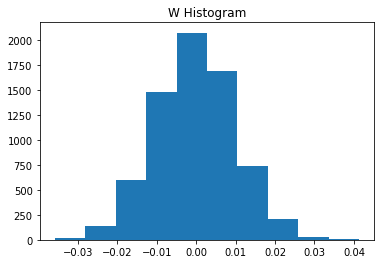

In [5]:
np.random.seed(2)
test = DLLinearLayer("Take1",7,1000,0.1,'adaptive')
print(test)
print("b.T=",test.b.T)
plt.hist(test.W.reshape(-1))
plt.title("W Histogram")
plt.show()

In [6]:
np.random.seed(1)
l = DLLinearLayer("Take2", 4, 4, 0.004, None)
l.W = DLLinearLayer.normal_initialization(l.W.shape,3)
prev_A = np.random.rand(4,2)
Z = l.forward_propagation(prev_A)
dZ = np.random.randn(4,2)
dA_prev = l.backward_propagation(dZ)
print(f"Z:\n{Z}")
print(f"dWs:\n{l.dW}")
print(f"dbs:\n{l.db}")
print(f"dA_prev:\n{dA_prev}")

Z:
[[ 0.49871006 -0.78718346]
 [ 2.85788617 -0.96396118]
 [-2.17470133  0.85832859]
 [-1.38220528 -0.40842505]]
dWs:
[[ 0.53587126  0.54830816  0.85551156  1.06180073]
 [-0.60626935 -0.2763047  -0.14166735 -0.2403767 ]
 [ 1.13442814  0.29130596 -0.27696928 -0.18062528]
 [-0.43143129 -0.15839972 -0.00901598 -0.06429584]]
dbs:
[[ 2.40184634]
 [-1.07946452]
 [ 0.94529631]
 [-0.58618789]]
dA_prev:
[[-2.28525484  7.63288036]
 [-3.41661272 -9.48753635]
 [-0.13864189 -1.60906444]
 [ 4.64991426 -4.03371276]]


In [7]:
np.random.seed(2)
l = DLLinearLayer("check b", 2, 3, 0.004, "adaptive")
X = np.array([[-1.1,2,6,1],[4,-3.1,8,0],[4,-31.1,-8,7]])
Z = l.forward_propagation(X)
dZ = np.random.randn(*Z.shape)*5
l.backward_propagation(dZ)
print(f"Before update:\nb:\n{l.b}\nW:\n{l.W}")
l.update_parameters()
print(f"After update:\nb:\n{l.b}\nW:\n{l.W}")

Before update:
b:
[[0.]
 [0.]]
W:
[[-0.00416758 -0.00056267 -0.02136196]
 [ 0.01640271 -0.01793436 -0.00841747]]
After update:
b:
[[ 0.002 ]
 [-0.0044]]
W:
[[-0.00216758  0.00143733 -0.02576196]
 [ 0.01200271 -0.01593436 -0.00641747]]


In [8]:
np.random.seed(1)
Z = np.random.randn(2,5)
s = DLActivation("sigmoid")
r = DLActivation("relu")
t = DLActivation("tanh")
l = DLActivation("leaky_relu")
try:
    e = DLActivation("error")
except Exception as e:
    print(e)
print(s)
print(r)
print(t)
print(l)
As = s.forward_propagation(Z)
Ar = r.forward_propagation(Z)
At = t.forward_propagation(Z)
Al = l.forward_propagation(Z)
print(f"As\n{As}")
print(f"Ar\n{Ar}")
print(f"At\n{At}")
print(f"Al\n{Al}")
dA = np.random.randn(2,5)*5
dZs = s.backward_propagation(dA)
dZr = r.backward_propagation(dA)
dZt = t.backward_propagation(dA)
dZl = t.backward_propagation(dA)
print(f"dZs\n{dZs}")
print(f"dZr\n{dZr}")
print(f"dZt\n{dZt}")
print(f"dZl\n{dZl}")

Activation function: sigmoid

Activation function: relu

Activation function: tanh

Activation function: leaky_relu

As
[[0.83539354 0.35165864 0.3709434  0.25483894 0.70378922]
 [0.09099561 0.85129722 0.31838429 0.57909005 0.43797848]]
Ar
[[1.62434536 0.         0.         0.         0.86540763]
 [0.         1.74481176 0.         0.3190391  0.        ]]
At
[[ 0.92525207 -0.5453623  -0.48398233 -0.79057703  0.69903334]
 [-0.98015695  0.94078216 -0.6417873   0.30863781 -0.24432671]]
Al
[[ 1.62434536 -0.00611756 -0.00528172 -0.01072969  0.86540763]
 [-0.02301539  1.74481176 -0.00761207  0.3190391  -0.0024937 ]]
dZs
[[ 1.0052809  -2.34850727 -0.37617123 -0.36465204  1.18178431]
 [-0.45488977 -0.10913866 -0.95254545  0.0514469   0.71730953]]
dZr
[[ 7.31053969 -0.         -0.         -0.          5.66884721]
 [-0.         -0.86214104 -0.          0.21106873  0.        ]]
dZt
[[ 1.05204952 -7.23706788 -1.23447277 -0.72007878  2.89877855]
 [-0.21608662 -0.09908494 -2.58138245  0.1909629   2.7

In [9]:
import h5py
import os
def load_datasetC1W2():
    return load_dataset(r'/drive/MyDrive/Data/unit10/datasets/cat_nocat')

def load_dataset(path):
    f = os.getcwd() + path
    train_dataset = h5py.File(f+r'/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File(f + r'/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


cat or not model
	Loss function: cross_entropy
	perceptron:
linear Function:
	learning_rate (alpha): 0.005
	Optimization: adaptive
		adaptive parameters:
			cont: 1.1
			switch: 0.5
	Parameters:
		W shape: (1, 12288)
		b: (1, 1)
		num units: 1
		input size: 12288
Activation function: sigmoid


cost after  3 updates (1%): 0.6406354326965208
cost after  5 updates (2%): 0.5544786131431865
cost after  7 updates (3%): 0.5302951350736529
cost after  9 updates (4%): 0.5162611173141808
cost after  11 updates (5%): 0.5025548085799304
cost after  13 updates (6%): 0.48685188749378844
cost after  15 updates (7%): 0.46924904494485253
cost after  17 updates (8%): 0.44980873557473927
cost after  19 updates (9%): 0.4285857234702996
cost after  21 updates (10%): 0.4056641040887211
cost after  23 updates (11%): 0.3811111397232976
cost after  25 updates (12%): 0.3550245062551433
cost after  27 updates (13%): 0.3274555272557818
cost after  29 updates (14%): 0.2994574430592563
cost after  31 updates (15%):

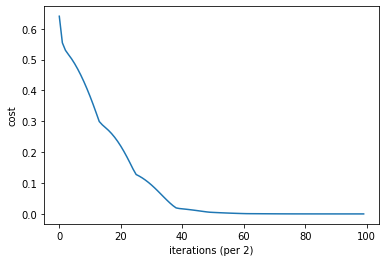

In [10]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_datasetC1W2()
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
train_set_x = train_set_x_flatten/255 - 0.5
test_set_x = test_set_x_flatten/255 - 0.5
num_px = train_set_x_orig.shape[1]
perceptron = DLNeuronsLayer("perceptron",1,num_px*num_px*3, "sigmoid", alpha=0.005,optimization='adaptive')
perceptron.linear.W = np.zeros((1,num_px*num_px*3), dtype="float")
model = DLModel("cat or not model", perceptron,"cross_entropy")
print(model)
costs = model.train(train_set_x, train_set_y,200)
u10.print_costs(costs,200)


In [11]:
np.random.seed(1)
hidden = DLNeuronsLayer("hidden",4,2, "tanh", alpha=0.1,optimization='adaptive')
output = DLNeuronsLayer("output",1,4, "sigmoid", alpha=0.1,optimization='adaptive')
my_first_ANN = DLNetwork("ny first Ann")
my_first_ANN.add(hidden)
my_first_ANN.add(output)
print(my_first_ANN)
print(hidden.linear.W)
print(output.linear.W)

ny first Ann:
hidden:
linear Function:
	learning_rate (alpha): 0.1
	Optimization: adaptive
		adaptive parameters:
			cont: 1.1
			switch: 0.5
	Parameters:
		W shape: (4, 2)
		b: (4, 1)
		num units: 4
		input size: 2
Activation function: tanh
output:
linear Function:
	learning_rate (alpha): 0.1
	Optimization: adaptive
		adaptive parameters:
			cont: 1.1
			switch: 0.5
	Parameters:
		W shape: (1, 4)
		b: (1, 1)
		num units: 1
		input size: 4
Activation function: sigmoid

[[ 0.01624345 -0.00611756]
 [-0.00528172 -0.01072969]
 [ 0.00865408 -0.02301539]
 [ 0.01744812 -0.00761207]]
[[ 0.00319039 -0.0024937   0.01462108 -0.02060141]]


cost after  11 updates (1%): 0.6561580759260928
cost after  21 updates (2%): 0.6295102136110079
cost after  31 updates (3%): 0.6067544163996677
cost after  41 updates (4%): 0.5999092927982893
cost after  51 updates (5%): 0.5945304086079389
cost after  61 updates (6%): 0.5763643785172391
cost after  71 updates (7%): 0.5085099006733498
cost after  81 updates (8%): 0.4659052212905812
cost after  91 updates (9%): 0.4393359196024623
cost after  101 updates (10%): 0.4020065696884483
cost after  111 updates (11%): 0.3727018448516946
cost after  121 updates (12%): 0.3438794101203568
cost after  131 updates (13%): 0.3230170559553421
cost after  141 updates (14%): 0.3136318318956267
cost after  151 updates (15%): 0.309986848893647
cost after  161 updates (16%): 0.3074204164757474
cost after  171 updates (17%): 0.30559398152482037
cost after  181 updates (18%): 0.30373017032654986
cost after  191 updates (19%): 0.30156600313732057
cost after  201 updates (20%): 0.29963739115383237
cost after  211

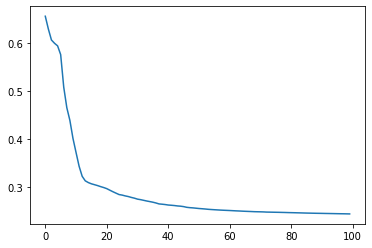

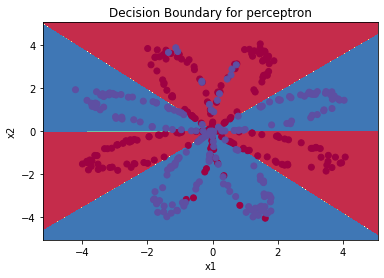

Accuracy: 90%


In [12]:
np.random.seed(1)
model = DLModel("first ann",my_first_ANN,"cross_entropy")
X, Y = u10.load_planar_dataset()
costs = model.train(X, Y,1000)
plt.plot(costs)
plt.show()

u10.plot_decision_boundary_sklearn(lambda x: model.forward_propagation(x.T) > 0.7, X, Y)
plt.title("Decision Boundary for perceptron")
plt.show()
predictions = model.forward_propagation(X) > 0.7
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')